In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from tqdm import tqdm

# Data Loading and Preprocessing
def load_all_folds(base_path):
    folds = ["Fold 1", "Fold 2", "Fold 3"]
    all_images, all_masks, all_types = [], [], []
    
    for fold in folds:
        fold_path = os.path.join(base_path, fold)
        images = np.load(os.path.join(fold_path, "images", f"fold{fold[-1]}", "images.npy"))
        masks = np.load(os.path.join(fold_path, "masks", f"fold{fold[-1]}", "masks.npy"))
        types = np.load(os.path.join(fold_path, "images", f"fold{fold[-1]}", "types.npy"))
        
        all_images.append(images)
        all_masks.append(masks)
        all_types.append(types)
    
    return all_images, all_masks, all_types

base_path = "/rsrch5/home/plm/yshokrollahi/vitamin-p/vitamin-p/data/raw/H&E"
all_images, all_masks, all_types = load_all_folds(base_path)

def create_train_val_test_split(all_images, all_masks, all_types):
    splits = []
    
    for test_fold in range(3):
        train_val_folds = [i for i in range(3) if i != test_fold]
        
        train_val_images = np.concatenate([all_images[i] for i in train_val_folds])
        train_val_masks = np.concatenate([all_masks[i] for i in train_val_folds])
        train_val_types = np.concatenate([all_types[i] for i in train_val_folds])
        
        num_samples = len(train_val_images)
        num_val = num_samples // 10
        
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        
        val_indices = indices[:num_val]
        train_indices = indices[num_val:]
        
        split = {
            'train': {
                'images': train_val_images[train_indices],
                'masks': train_val_masks[train_indices],
                'types': train_val_types[train_indices]
            },
            'val': {
                'images': train_val_images[val_indices],
                'masks': train_val_masks[val_indices],
                'types': train_val_types[val_indices]
            },
            'test': {
                'images': all_images[test_fold],
                'masks': all_masks[test_fold],
                'types': all_types[test_fold]
            }
        }
        
        splits.append(split)
    
    return splits

data_splits = create_train_val_test_split(all_images, all_masks, all_types)
print("done")


/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


done


In [2]:
import torch
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as TF
from scipy.ndimage import gaussian_filter, map_coordinates
from skimage.segmentation import slic

class CellSegmentationDataset(Dataset):
    def __init__(self, images, masks, image_transform=None, mask_transform=None, augment=False):
        self.images = images
        self.masks = masks
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # Normalize image to 0-1 range and convert to float32
        image = ((image - image.min()) / (image.max() - image.min())).astype(np.float32)
        
        # Create binary mask from the last channel and convert to float32
        binary_mask = (mask[..., 5] > 0).astype(np.float32)

        if self.augment:
            image, binary_mask = self.apply_augmentation(image, binary_mask)

        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            binary_mask = self.mask_transform(binary_mask)

        return image, binary_mask

    def apply_augmentation(self, image, mask):
        # Convert numpy arrays to tensors
        image = torch.from_numpy(image).permute(2, 0, 1)
        mask = torch.from_numpy(mask).unsqueeze(0)

        original_size = image.shape[1:]

        # Random 90-degree rotation
        if torch.rand(1) < 0.5:
            k = torch.randint(1, 4, (1,)).item()
            image = torch.rot90(image, k, [1, 2])
            mask = torch.rot90(mask, k, [1, 2])

        # Random horizontal flip
        if torch.rand(1) < 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flip
        if torch.rand(1) < 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Random scaling (downscaling)
        if torch.rand(1) < 0.5:
            scale_factor = torch.FloatTensor(1).uniform_(0.8, 1.0).item()
            new_size = [max(224, int(s * scale_factor)) for s in image.shape[1:]]
            image = TF.resize(image, new_size)
            mask = TF.resize(mask, new_size)

        # Elastic transformation
        if torch.rand(1) < 0.5:
            image = self.elastic_transform(image.permute(1, 2, 0).numpy())
            mask = self.elastic_transform(mask.squeeze().numpy())
            image = torch.from_numpy(image).permute(2, 0, 1)
            mask = torch.from_numpy(mask).unsqueeze(0)

        # Ensure image is large enough for subsequent operations
        if min(image.shape[1:]) < 224:
            scale_factor = 224 / min(image.shape[1:])
            new_size = [int(s * scale_factor) for s in image.shape[1:]]
            image = TF.resize(image, new_size)
            mask = TF.resize(mask, new_size)

        # Blurring
        if torch.rand(1) < 0.5:
            sigma = torch.FloatTensor(1).uniform_(0.1, 2.0).item()
            image = torch.from_numpy(gaussian_filter(image.numpy(), sigma=(0, sigma, sigma)))

        # Gaussian noise
        if torch.rand(1) < 0.5:
            noise = torch.randn_like(image) * 0.1
            image = image + noise
            image = torch.clamp(image, 0, 1)

        # Color jittering
        if torch.rand(1) < 0.5:
            brightness_factor = torch.tensor(1.0).uniform_(0.8, 1.2).item()
            contrast_factor = torch.tensor(1.0).uniform_(0.8, 1.2).item()
            saturation_factor = torch.tensor(1.0).uniform_(0.8, 1.2).item()
            hue_factor = torch.tensor(1.0).uniform_(-0.1, 0.1).item()
            image = TF.adjust_brightness(image, brightness_factor)
            image = TF.adjust_contrast(image, contrast_factor)
            image = TF.adjust_saturation(image, saturation_factor)
            image = TF.adjust_hue(image, hue_factor)

        # SLIC superpixels
        if torch.rand(1) < 0.5:
            image = self.apply_slic(image)

        # Zoom blur
        if torch.rand(1) < 0.5:
            image = self.zoom_blur(image)

        # Random cropping with resizing
        if torch.rand(1) < 0.5:
            i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(224, 224))
            image = TF.crop(image, i, j, h, w)
            mask = TF.crop(mask, i, j, h, w)

        # Resize back to original size
        image = TF.resize(image, original_size)
        mask = TF.resize(mask, original_size)

        return image, mask

    def elastic_transform(self, image, alpha=1, sigma=0.1, alpha_affine=0.1):
        """Elastic deformation of images as described in [Simard2003]_."""
        random_state = np.random.RandomState(None)

        shape = image.shape[:2]
        
        # Random affine
        center_square = np.float32(shape) // 2
        square_size = min(shape) // 3
        pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
        pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
        M = cv2.getAffineTransform(pts1, pts2)
        image = cv2.warpAffine(image, M, shape[::-1], borderMode=cv2.BORDER_REFLECT_101)

        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

        if image.ndim == 2:
            return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
        else:
            result = np.zeros_like(image)
            for i in range(image.shape[2]):
                result[:,:,i] = map_coordinates(image[:,:,i], indices, order=1, mode='reflect').reshape(shape)
            return result

    def apply_slic(self, image):
        image_np = image.numpy().transpose(1, 2, 0)
        segments = slic(image_np, n_segments=100, compactness=10, sigma=1)
        out = np.zeros_like(image_np)
        for i in np.unique(segments):
            mask = segments == i
            out[mask] = np.mean(image_np[mask], axis=0)
        return torch.from_numpy(out.transpose(2, 0, 1))

    def zoom_blur(self, image, max_factor=1.2):
        c, h, w = image.shape
        zoom_factor = torch.FloatTensor(1).uniform_(1, max_factor).item()
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        zoom_image = TF.resize(image, (zh, zw))
        zoom_image = TF.center_crop(zoom_image, (h, w))
        return (image + zoom_image) / 2

# Usage example remains the same

# Usage example
chosen_split = 1

# Define transforms
image_transform = transforms.Compose([
    transforms.Lambda(lambda x: x if isinstance(x, torch.Tensor) else torch.from_numpy(x).permute(2, 0, 1)),
    transforms.Lambda(lambda x: x.float())
])

mask_transform = transforms.Compose([
    transforms.Lambda(lambda x: x if isinstance(x, torch.Tensor) else torch.from_numpy(x).unsqueeze(0)),
    transforms.Lambda(lambda x: x.float())
])

# Create datasets
train_dataset = CellSegmentationDataset(
    data_splits[chosen_split]['train']['images'],
    data_splits[chosen_split]['train']['masks'],
    image_transform=image_transform,
    mask_transform=mask_transform,
    augment=True  # Enable augmentation for training set
)

val_dataset = CellSegmentationDataset(
    data_splits[chosen_split]['val']['images'],
    data_splits[chosen_split]['val']['masks'],
    image_transform=image_transform,
    mask_transform=mask_transform,
    augment=False  # No augmentation for validation set
)

test_dataset = CellSegmentationDataset(
    data_splits[chosen_split]['test']['images'],
    data_splits[chosen_split]['test']['masks'],
    image_transform=image_transform,
    mask_transform=mask_transform,
    augment=False  # No augmentation for test set
)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Check first item in train_dataset
print("\nChecking first item in train_dataset:")
image, mask = train_dataset[0]
print(f"Final image shape: {image.shape}, dtype: {image.dtype}")
print(f"Final mask shape: {mask.shape}, dtype: {mask.dtype}")
print(f"Final image min: {image.min().item():.4f}, max: {image.max().item():.4f}")
print(f"Final mask min: {mask.min().item():.4f}, max: {mask.max().item():.4f}")


Checking first item in train_dataset:
Final image shape: torch.Size([3, 256, 256]), dtype: torch.float32
Final mask shape: torch.Size([1, 256, 256]), dtype: torch.float32
Final image min: 0.1201, max: 0.8797
Final mask min: 0.0000, max: 1.0000


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


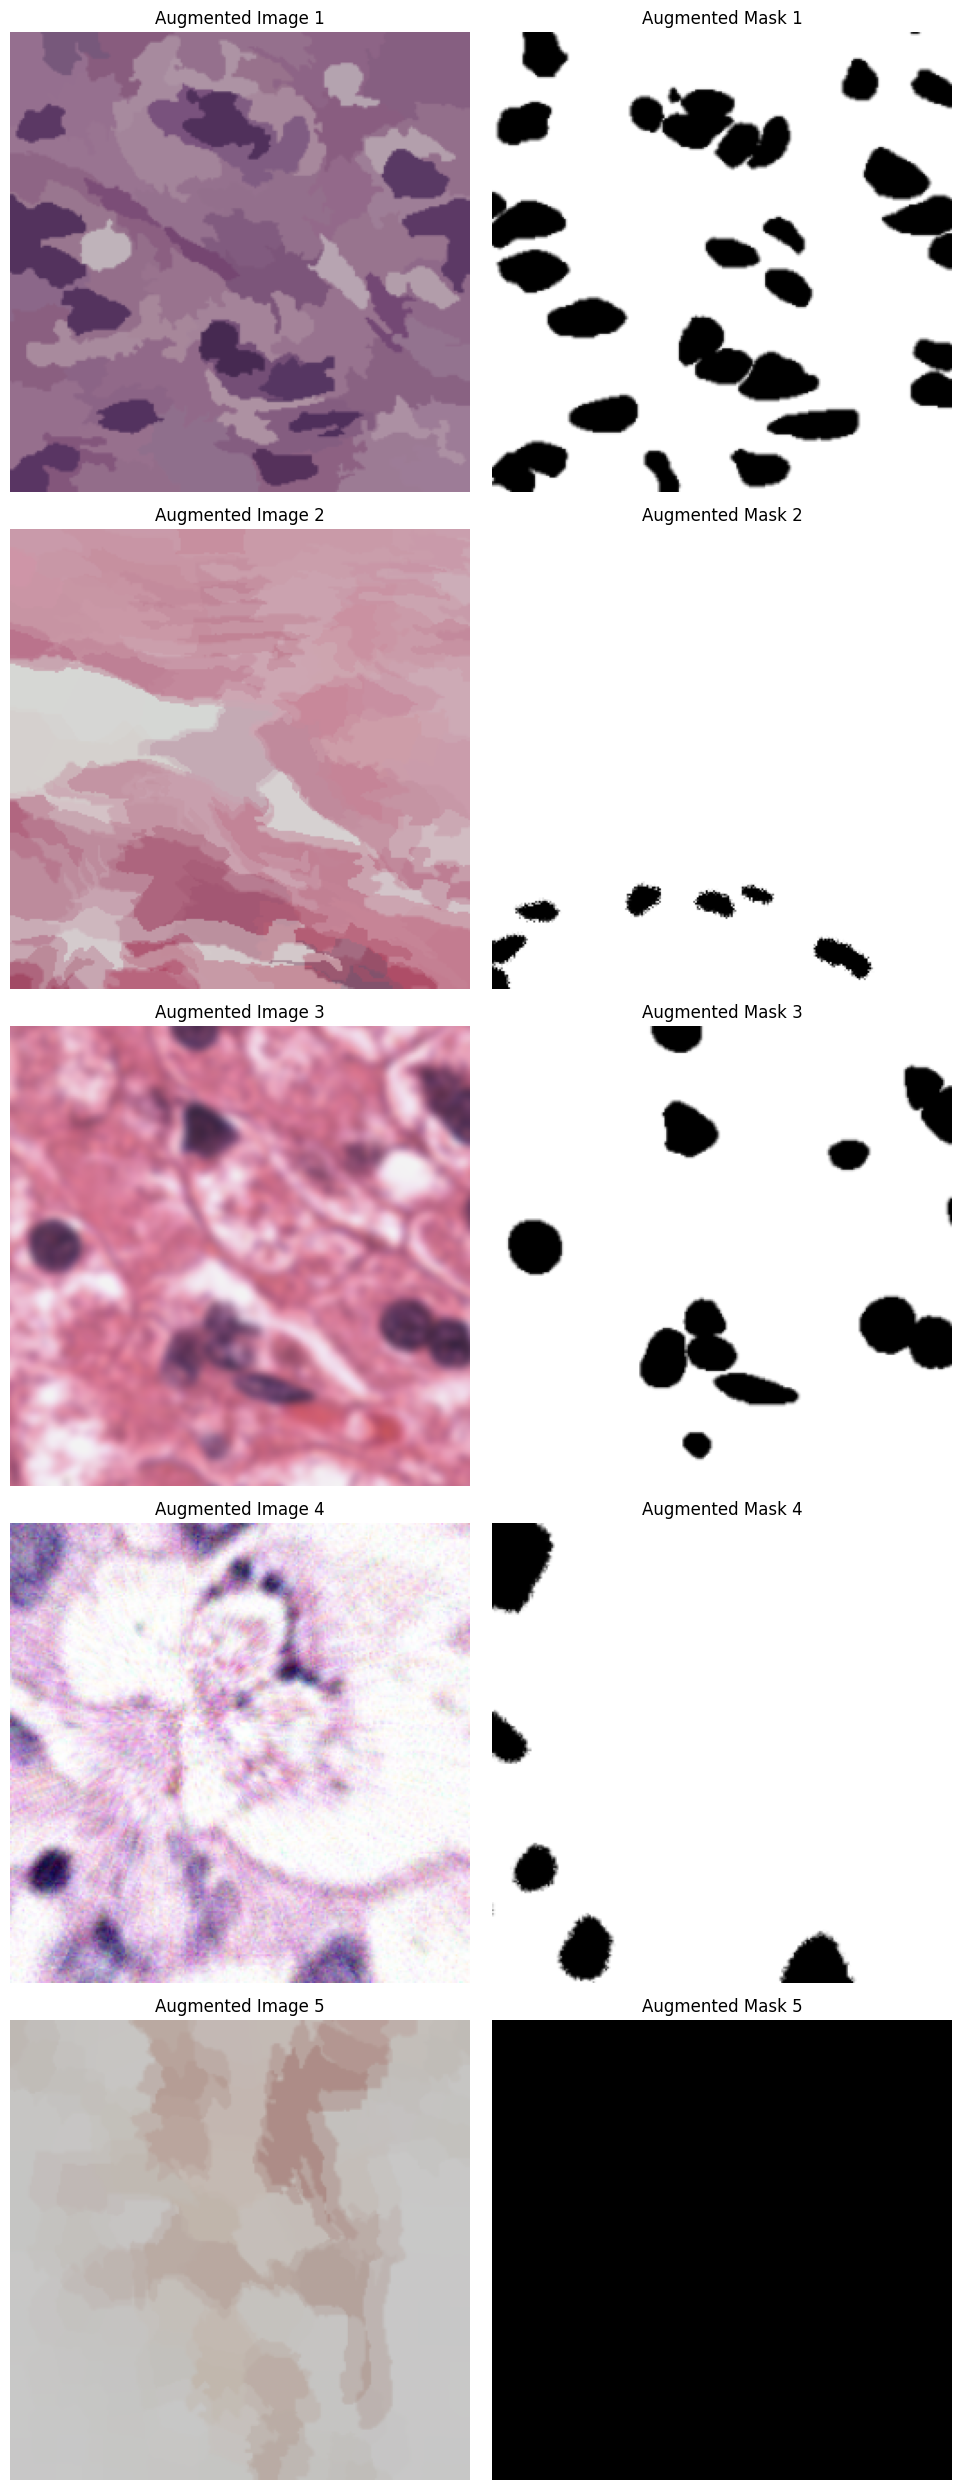

In [3]:
import matplotlib.pyplot as plt

def visualize_augmented_images(dataset, num_samples=5):
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))
    for i in range(num_samples):
        image, mask = dataset[i]
        axs[i, 0].imshow(image.permute(1, 2, 0))
        axs[i, 0].set_title(f"Augmented Image {i+1}")
        axs[i, 0].axis('off')
        axs[i, 1].imshow(mask.squeeze(), cmap='gray')
        axs[i, 1].set_title(f"Augmented Mask {i+1}")
        axs[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

# Usage
visualize_augmented_images(train_dataset)

## Data visualization

Visualizing first sample from training dataset:
Original image - min: 0.0, max: 255.0, mean: 143.33145650227866
Normalized image - min: 0.0, max: 1.0, mean: 0.5620841431461907


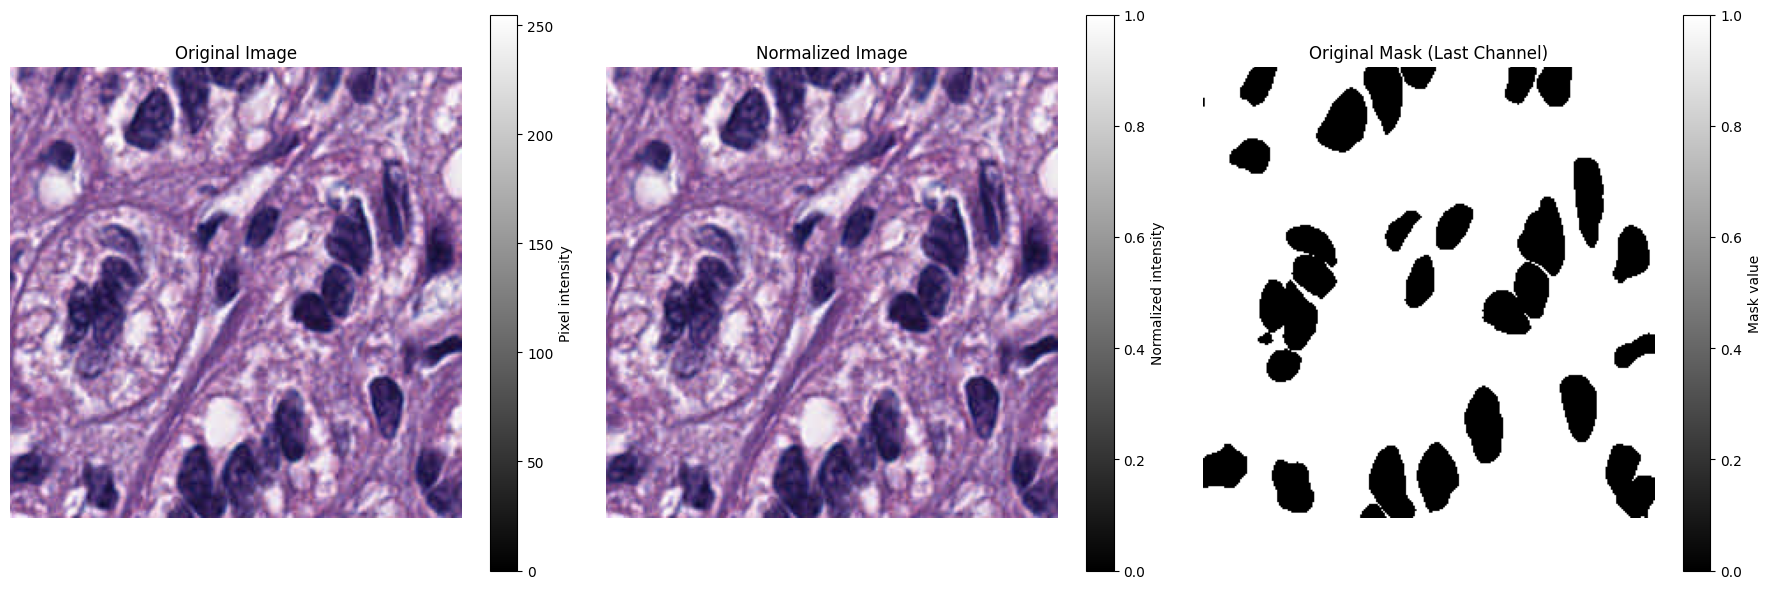

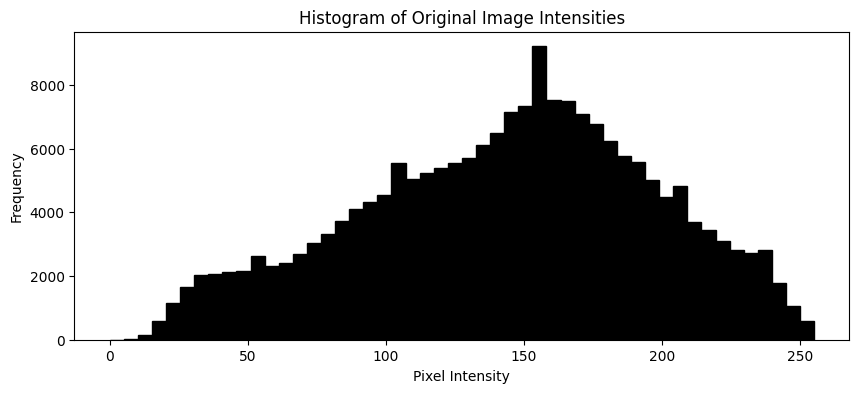

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_single_sample(dataset, index=0):
    # Get the original image and mask
    original_image = dataset.images[index]
    original_mask = dataset.masks[index]

    # Normalize image as done in the dataset class
    normalized_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())

    print(f"Original image - min: {original_image.min()}, max: {original_image.max()}, mean: {original_image.mean()}")
    print(f"Normalized image - min: {normalized_image.min()}, max: {normalized_image.max()}, mean: {normalized_image.mean()}")

    # Create a figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Plot the original image
    # Plot the original image with adjusted vmin and vmax
    im1 = ax1.imshow(original_image.astype(np.uint8), cmap='gray', vmin=0, vmax=255)
    ax1.set_title("Original Image")
    ax1.axis('off')
    plt.colorbar(im1, ax=ax1, label='Pixel intensity')

    # Plot the normalized image
    im2 = ax2.imshow(normalized_image, cmap='gray')
    ax2.set_title("Normalized Image")
    ax2.axis('off')
    plt.colorbar(im2, ax=ax2, label='Normalized intensity')

    # Plot the original mask (last channel)
    im3 = ax3.imshow(original_mask[..., -1], cmap='gray')
    ax3.set_title("Original Mask (Last Channel)")
    ax3.axis('off')
    plt.colorbar(im3, ax=ax3, label='Mask value')

    plt.tight_layout()
    plt.show()

    # Display histogram of original image intensities
    plt.figure(figsize=(10, 4))
    plt.hist(original_image.ravel(), bins=50, range=(original_image.min(), original_image.max()), fc='k', ec='k')
    plt.title("Histogram of Original Image Intensities")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

# Visualize the first sample from the training dataset
print("Visualizing first sample from training dataset:")
visualize_single_sample(train_dataset)

Visualizing random samples from training dataset:

Visualiizng sample 2553:
Original image - min: 93.0, max: 255.0, mean: 234.58
Normalized image - min: 0.00, max: 1.00, mean: 0.87


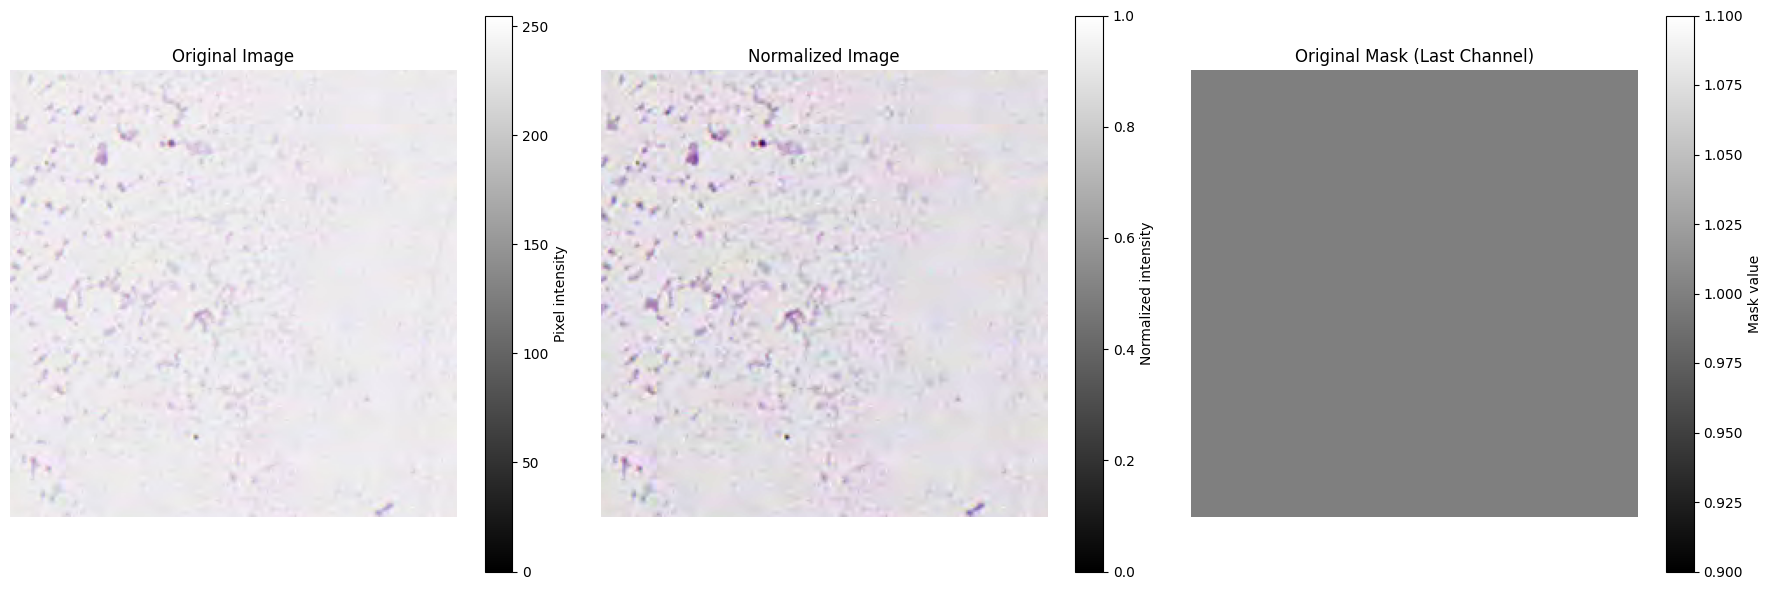


Visualiizng sample 2526:
Original image - min: 22.0, max: 255.0, mean: 194.89
Normalized image - min: 0.00, max: 1.00, mean: 0.74


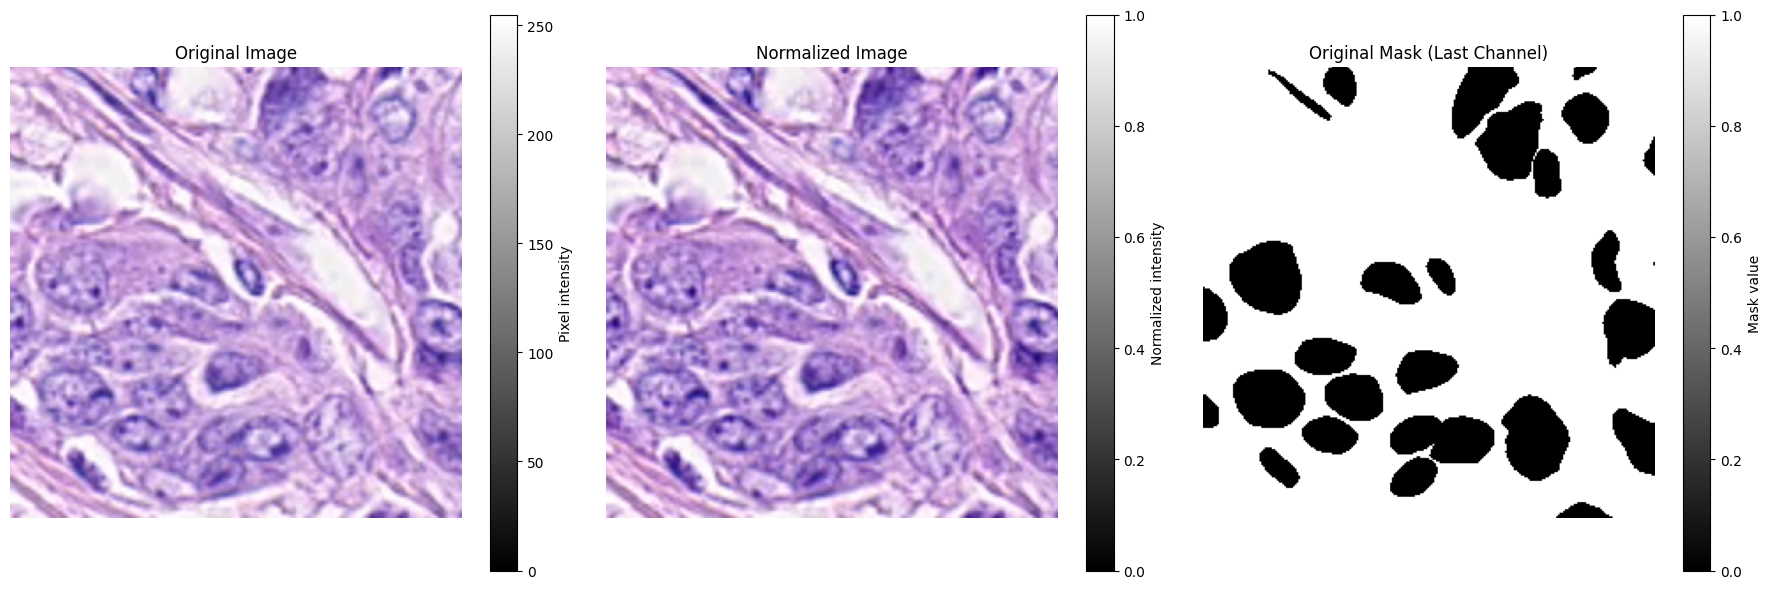


Visualiizng sample 4503:
Original image - min: 44.0, max: 255.0, mean: 195.90
Normalized image - min: 0.00, max: 1.00, mean: 0.72


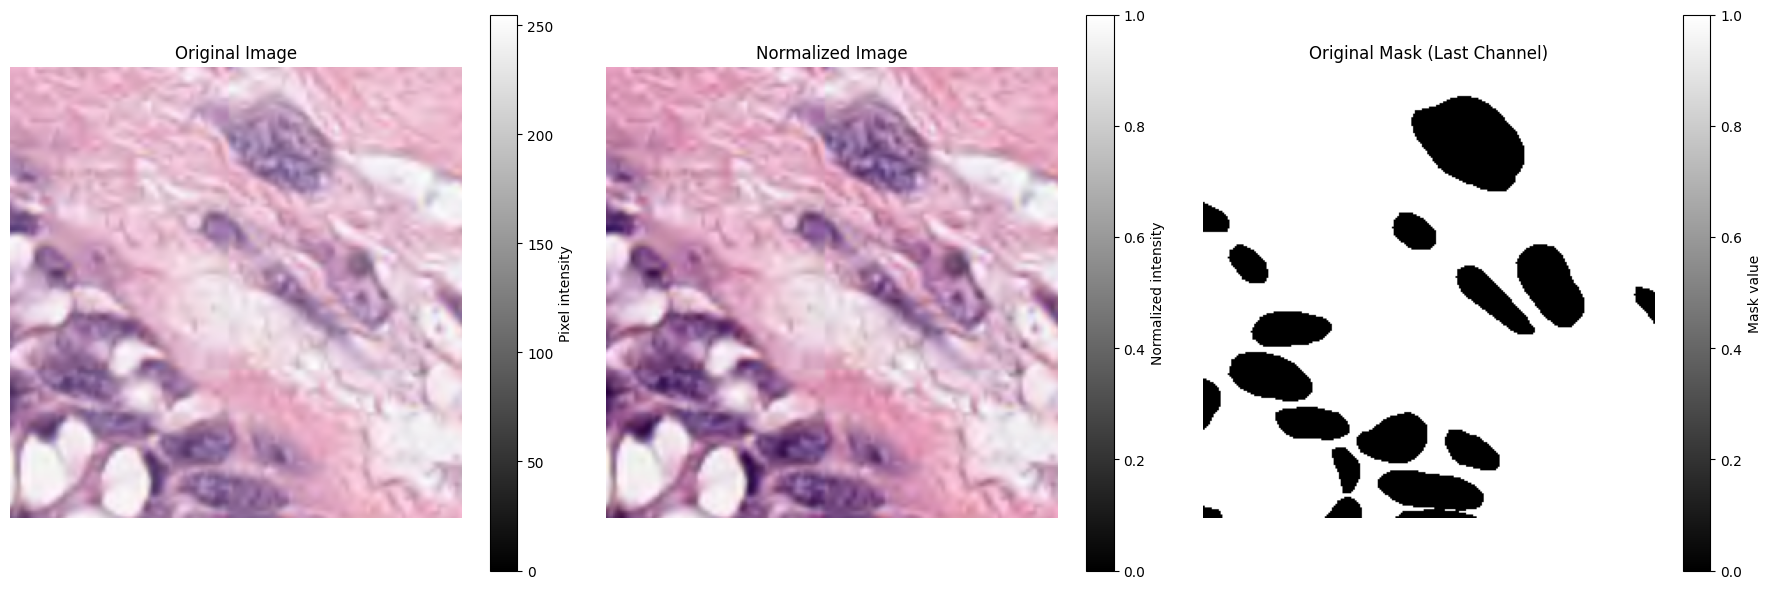

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import random

def visualize_random_samples(dataset, num_samples=3):
    # Get the total number of samples in the dataset
    total_samples = len(dataset)
    
    # Generate random indices
    random_indices = random.sample(range(total_samples), num_samples)
    
    for index in random_indices:
        visualize_single_sample(dataset, index)

def visualize_single_sample(dataset, index):
    # Get the original image and mask
    original_image = dataset.images[index]
    original_mask = dataset.masks[index]

    # Normalize image as done in the dataset class
    normalized_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())

    print(f"\nVisualiizng sample {index}:")
    print(f"Original image - min: {original_image.min()}, max: {original_image.max()}, mean: {original_image.mean():.2f}")
    print(f"Normalized image - min: {normalized_image.min():.2f}, max: {normalized_image.max():.2f}, mean: {normalized_image.mean():.2f}")

    # Create a figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Plot the original image
    im1 = ax1.imshow(original_image.astype(np.uint8), cmap='gray', vmin=0, vmax=255)
    ax1.set_title("Original Image")
    ax1.axis('off')
    plt.colorbar(im1, ax=ax1, label='Pixel intensity')

    # Plot the normalized image
    im2 = ax2.imshow(normalized_image, cmap='gray')
    ax2.set_title("Normalized Image")
    ax2.axis('off')
    plt.colorbar(im2, ax=ax2, label='Normalized intensity')

    # Plot the original mask (last channel)
    im3 = ax3.imshow(original_mask[..., -1], cmap='gray')
    ax3.set_title("Original Mask (Last Channel)")
    ax3.axis('off')
    plt.colorbar(im3, ax=ax3, label='Mask value')

    plt.tight_layout()
    plt.show()

    # # Display histogram of original image intensities
    # plt.figure(figsize=(10, 4))
    # plt.hist(original_image.ravel(), bins=50, range=(original_image.min(), original_image.max()), fc='k', ec='k')
    # plt.title(f"Histogram of Original Image Intensities (Sample {index})")
    # plt.xlabel("Pixel Intensity")
    # plt.ylabel("Frequency")
    # plt.show()

# Visualize random samples from the training dataset
print("Visualizing random samples from training dataset:")
visualize_random_samples(train_dataset, num_samples=3)

## model training 

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import swin_t, Swin_T_Weights

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(min(32, out_channels), out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(min(32, out_channels), out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.se = SEBlock(out_channels, reduction=8)
        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        residual = self.residual_conv(x)
        x = self.relu(self.norm1(self.conv1(x)))
        x = self.relu(self.norm2(self.conv2(x)))
        x = self.se(x)
        return x + residual

class SwinEncoder(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        if pretrained:
            weights = Swin_T_Weights.IMAGENET1K_V1
        else:
            weights = None
        self.swin = swin_t(weights=weights)
        self.swin.head = nn.Identity()  # Remove the classifier head

    def forward(self, x):
        features = []
        for i, layer in enumerate(self.swin.features):
            x = layer(x)
            if i in [2, 4, 6]:  # Collect features from specific layers
                features.append(x)
        return features

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.GroupNorm(min(32, F_int), F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.GroupNorm(min(32, F_int), F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.GroupNorm(1, 1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class FPN(nn.Module):
    def __init__(self, in_channels_list, out_channels):
        super(FPN, self).__init__()
        self.lateral_convs = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
            for in_channels in in_channels_list
        ])
        self.smooth_convs = nn.ModuleList([
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
            for _ in in_channels_list
        ])

    def forward(self, features):
        results = []
        last_feature = self.lateral_convs[-1](features[-1])
        results.append(self.smooth_convs[-1](last_feature))

        for i in range(len(features) - 2, -1, -1):
            lateral = self.lateral_convs[i](features[i])
            top_down = F.interpolate(last_feature, scale_factor=2, mode='nearest')
            last_feature = lateral + top_down
            results.insert(0, self.smooth_convs[i](last_feature))

        return results

class UNetDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fpn = FPN([192, 384, 768], 256)
        self.decoder1 = DecoderBlock(256, 128)
        self.decoder2 = DecoderBlock(128, 64)
        self.decoder3 = DecoderBlock(64, 32)
        self.decoder4 = DecoderBlock(32, 16)
        self.final_conv = nn.Conv2d(16, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, features):
        fpn_features = self.fpn([f.permute(0, 3, 1, 2) for f in features])
        
        x = self.decoder1(fpn_features[-1])
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        x = self.decoder2(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        x = self.decoder3(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        x = self.decoder4(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        x = self.final_conv(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        return self.sigmoid(x)

class CellSwin(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = SwinEncoder()
        self.decoder = UNetDecoder()

    def forward(self, x):
        features = self.encoder(x)
        output = self.decoder(features)
        return output

# Initialize the model
model = CellSwin().float()
print("Further improved Swin Transformer-based model defined.")


# Example usage of the combined loss
# criterion = CombinedLoss(weight=0.5)
# loss = criterion(model_output, target)

Further improved Swin Transformer-based model defined.


## New Model

In [7]:
class FocalDiceLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, smooth=1e-5):
        super(FocalDiceLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, pred, target):
        # Focal Loss
        bce = F.binary_cross_entropy(pred, target, reduction='none')
        pt = torch.exp(-bce)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce
        focal_loss = focal_loss.mean()

        # Dice Loss
        pred = pred.view(-1)
        target = target.view(-1)
        intersection = (pred * target).sum()
        dice = 1 - (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)

        return focal_loss + dice
    
    


def iou_score(pred, target, smooth=1e-5, threshold=0.2):
    pred = (pred > threshold).float()
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = (pred + target).sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

print("Loss function and metrics defined.")



Loss function and metrics defined.


In [8]:
import numpy as np
from scipy import ndimage

def calculate_object_based_metrics(true_mask, pred_mask, distance_threshold=12):
    def get_centroids(mask):
        mask_np = mask.cpu().numpy() if isinstance(mask, torch.Tensor) else mask
        labeled, num_objects = ndimage.label(mask_np)
        if num_objects == 0:
            return np.array([])
        centroids = ndimage.center_of_mass(mask_np, labeled, range(1, num_objects+1))
        return np.array(centroids)

    true_centroids = get_centroids(true_mask)
    pred_centroids = get_centroids(pred_mask)

    if len(true_centroids) == 0 and len(pred_centroids) == 0:
        return 1.0, 1.0, 1.0  # Perfect score if both are empty
    elif len(true_centroids) == 0:
        return 0.0, 0.0, 0.0  # All false positives
    elif len(pred_centroids) == 0:
        return 0.0, 0.0, 0.0  # All false negatives

    matched = set()
    tp = 0

    for pred_centroid in pred_centroids:
        distances = np.sqrt(((true_centroids - pred_centroid[np.newaxis, :]) ** 2).sum(axis=1))
        if distances.size > 0 and np.min(distances) <= distance_threshold:
            match_idx = np.argmin(distances)
            if match_idx not in matched:
                tp += 1
                matched.add(match_idx)

    fp = len(pred_centroids) - tp
    fn = len(true_centroids) - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

## #new 

In [9]:
import torch
from tqdm import tqdm
import os
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau


def train_model(model, train_loader, val_loader, num_epochs=100, patience=20, save_dir='models'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = FocalDiceLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
    
    os.makedirs(save_dir, exist_ok=True)
    best_val_loss = float('inf')
    best_model = None
    counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_iou = 0
        train_precision = 0
        train_recall = 0
        train_f1 = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")
        for images, masks in train_bar:
            images = images.float().to(device)
            masks = masks.float().to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_iou += iou_score(outputs, masks).item()
            
            # Calculate object-based metrics
            pred_masks = (outputs > 0.5).float()
            batch_precision, batch_recall, batch_f1 = 0, 0, 0
            for true_mask, pred_mask in zip(masks, pred_masks):
                p, r, f = calculate_object_based_metrics(true_mask, pred_mask)
                batch_precision += p
                batch_recall += r
                batch_f1 += f
            
            train_precision += batch_precision / len(masks)
            train_recall += batch_recall / len(masks)
            train_f1 += batch_f1 / len(masks)
            
            train_bar.set_postfix({
                'loss': f"{loss.item():.4f}", 
                'iou': f"{iou_score(outputs, masks).item():.4f}",
                'precision': f"{batch_precision / len(masks):.4f}",
                'recall': f"{batch_recall / len(masks):.4f}",
                'f1': f"{batch_f1 / len(masks):.4f}"
            })
        
        avg_train_loss = train_loss / len(train_loader)
        avg_train_iou = train_iou / len(train_loader)
        avg_train_precision = train_precision / len(train_loader)
        avg_train_recall = train_recall / len(train_loader)
        avg_train_f1 = train_f1 / len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0
        val_iou = 0
        val_precision = 0
        val_recall = 0
        val_f1 = 0
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation")
        with torch.no_grad():
            for images, masks in val_bar:
                images = images.float().to(device)
                masks = masks.float().to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                val_iou += iou_score(outputs, masks).item()
                
                # Calculate object-based metrics
                pred_masks = (outputs > 0.5).float()
                batch_precision, batch_recall, batch_f1 = 0, 0, 0
                for true_mask, pred_mask in zip(masks, pred_masks):
                    p, r, f = calculate_object_based_metrics(true_mask, pred_mask)
                    batch_precision += p
                    batch_recall += r
                    batch_f1 += f
                
                val_precision += batch_precision / len(masks)
                val_recall += batch_recall / len(masks)
                val_f1 += batch_f1 / len(masks)
                
                val_bar.set_postfix({
                    'loss': f"{loss.item():.4f}", 
                    'iou': f"{iou_score(outputs, masks).item():.4f}",
                    'precision': f"{batch_precision / len(masks):.4f}",
                    'recall': f"{batch_recall / len(masks):.4f}",
                    'f1': f"{batch_f1 / len(masks):.4f}"
                })
        
        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        avg_val_precision = val_precision / len(val_loader)
        avg_val_recall = val_recall / len(val_loader)
        avg_val_f1 = val_f1 / len(val_loader)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f}, Train IoU: {avg_train_iou:.4f}, Train Precision: {avg_train_precision:.4f}, Train Recall: {avg_train_recall:.4f}, Train F1: {avg_train_f1:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Val IoU: {avg_val_iou:.4f}, Val Precision: {avg_val_precision:.4f}, Val Recall: {avg_val_recall:.4f}, Val F1: {avg_val_f1:.4f}')
        
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict()
            counter = 0
            save_path = os.path.join(save_dir, 'v3.pth')
            torch.save(best_model, save_path)
            print(f"Saved best model with validation loss: {best_val_loss:.4f}")
        else:
            counter += 1
        
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    model.load_state_dict(best_model)
    return model

print("Updated training function with precision, recall, and F1 score calculations.")

Updated training function with precision, recall, and F1 score calculations.


In [10]:
!pwd

/rsrch5/home/plm/yshokrollahi/vitamin-p/new-vitamin-p


In [11]:
# Initialize the model
model = CellSwin().float()

# Train the model
trained_model = train_model(model, train_loader, val_loader, num_epochs=100, patience=100, save_dir='models/')

Epoch 1/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.22it/s, loss=0.3212, iou=0.7245, precision=0.8889, recall=0.4185, f1=0.5202]


Epoch 1/100:
Train Loss: 0.2152, Train IoU: 0.8105, Train Precision: 0.9074, Train Recall: 0.7080, Train F1: 0.7375
Val Loss: 0.1713, Val IoU: 0.8128, Val Precision: 0.9523, Val Recall: 0.5542, Val F1: 0.6230
Saved best model with validation loss: 0.1713


Epoch 2/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.29it/s, loss=0.2971, iou=0.7344, precision=0.8889, recall=0.4296, f1=0.5370]


Epoch 2/100:
Train Loss: 0.1606, Train IoU: 0.8202, Train Precision: 0.9076, Train Recall: 0.7202, Train F1: 0.7426
Val Loss: 0.1435, Val IoU: 0.8270, Val Precision: 0.9021, Val Recall: 0.5566, Val F1: 0.6120
Saved best model with validation loss: 0.1435


Epoch 3/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.25it/s, loss=0.3352, iou=0.7418, precision=0.8889, recall=0.4296, f1=0.5370]


Epoch 3/100:
Train Loss: 0.1443, Train IoU: 0.8323, Train Precision: 0.8995, Train Recall: 0.7324, Train F1: 0.7472
Val Loss: 0.1258, Val IoU: 0.8392, Val Precision: 0.8740, Val Recall: 0.5531, Val F1: 0.6054
Saved best model with validation loss: 0.1258


Epoch 4/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.06it/s, loss=0.3707, iou=0.7451, precision=0.8519, recall=0.4296, f1=0.5342]


Epoch 4/100:
Train Loss: 0.1376, Train IoU: 0.8370, Train Precision: 0.9034, Train Recall: 0.7306, Train F1: 0.7465
Val Loss: 0.1250, Val IoU: 0.8460, Val Precision: 0.9020, Val Recall: 0.5628, Val F1: 0.6204
Saved best model with validation loss: 0.1250


Epoch 5/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.77it/s, loss=0.1969, iou=0.7500, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 5/100:
Train Loss: 0.1323, Train IoU: 0.8425, Train Precision: 0.9062, Train Recall: 0.7230, Train F1: 0.7405
Val Loss: 0.1270, Val IoU: 0.8469, Val Precision: 0.9110, Val Recall: 0.5567, Val F1: 0.6195


Epoch 6/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.01it/s, loss=0.3283, iou=0.7548, precision=0.8519, recall=0.4296, f1=0.5342]


Epoch 6/100:
Train Loss: 0.1280, Train IoU: 0.8457, Train Precision: 0.9049, Train Recall: 0.7353, Train F1: 0.7496
Val Loss: 0.1159, Val IoU: 0.8547, Val Precision: 0.8974, Val Recall: 0.5595, Val F1: 0.6186
Saved best model with validation loss: 0.1159


Epoch 7/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.16it/s, loss=0.3402, iou=0.7553, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 7/100:
Train Loss: 0.1259, Train IoU: 0.8488, Train Precision: 0.8990, Train Recall: 0.7414, Train F1: 0.7509
Val Loss: 0.1140, Val IoU: 0.8570, Val Precision: 0.8843, Val Recall: 0.5578, Val F1: 0.6121
Saved best model with validation loss: 0.1140


Epoch 8/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.23it/s, loss=0.3331, iou=0.7623, precision=0.8056, recall=0.4296, f1=0.5132]


Epoch 8/100:
Train Loss: 0.1228, Train IoU: 0.8533, Train Precision: 0.9061, Train Recall: 0.7382, Train F1: 0.7510
Val Loss: 0.1080, Val IoU: 0.8669, Val Precision: 0.8951, Val Recall: 0.5638, Val F1: 0.6164
Saved best model with validation loss: 0.1080


Epoch 9/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.08it/s, loss=0.3737, iou=0.7617, precision=0.8056, recall=0.4296, f1=0.5132]


Epoch 9/100:
Train Loss: 0.1202, Train IoU: 0.8555, Train Precision: 0.9076, Train Recall: 0.7506, Train F1: 0.7599
Val Loss: 0.1136, Val IoU: 0.8643, Val Precision: 0.8767, Val Recall: 0.5646, Val F1: 0.6159


Epoch 10/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.54it/s, loss=0.3252, iou=0.7701, precision=0.7407, recall=0.4296, f1=0.5120]


Epoch 10/100:
Train Loss: 0.1202, Train IoU: 0.8570, Train Precision: 0.9023, Train Recall: 0.7416, Train F1: 0.7508
Val Loss: 0.1101, Val IoU: 0.8785, Val Precision: 0.8268, Val Recall: 0.5617, Val F1: 0.6048


Epoch 11/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.44it/s, loss=0.3545, iou=0.7664, precision=0.8889, recall=0.4296, f1=0.5370]


Epoch 11/100:
Train Loss: 0.1171, Train IoU: 0.8593, Train Precision: 0.9075, Train Recall: 0.7506, Train F1: 0.7588
Val Loss: 0.1069, Val IoU: 0.8739, Val Precision: 0.9025, Val Recall: 0.5658, Val F1: 0.6245
Saved best model with validation loss: 0.1069


Epoch 12/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.22it/s, loss=0.3213, iou=0.7640, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 12/100:
Train Loss: 0.1194, Train IoU: 0.8583, Train Precision: 0.9058, Train Recall: 0.7472, Train F1: 0.7576
Val Loss: 0.1035, Val IoU: 0.8699, Val Precision: 0.8840, Val Recall: 0.5640, Val F1: 0.6190
Saved best model with validation loss: 0.1035


Epoch 13/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.46it/s, loss=0.2845, iou=0.7626, precision=0.8889, recall=0.4296, f1=0.5370]


Epoch 13/100:
Train Loss: 0.1152, Train IoU: 0.8612, Train Precision: 0.9057, Train Recall: 0.7439, Train F1: 0.7544
Val Loss: 0.1016, Val IoU: 0.8742, Val Precision: 0.9305, Val Recall: 0.5681, Val F1: 0.6334
Saved best model with validation loss: 0.1016


Epoch 14/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.35it/s, loss=0.3509, iou=0.7656, precision=0.8519, recall=0.4296, f1=0.5342]


Epoch 14/100:
Train Loss: 0.1154, Train IoU: 0.8617, Train Precision: 0.9083, Train Recall: 0.7459, Train F1: 0.7568
Val Loss: 0.1012, Val IoU: 0.8681, Val Precision: 0.9341, Val Recall: 0.5658, Val F1: 0.6331
Saved best model with validation loss: 0.1012


Epoch 15/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.41it/s, loss=0.2964, iou=0.7677, precision=0.8889, recall=0.4296, f1=0.5370]


Epoch 15/100:
Train Loss: 0.1127, Train IoU: 0.8647, Train Precision: 0.9084, Train Recall: 0.7477, Train F1: 0.7561
Val Loss: 0.1046, Val IoU: 0.8735, Val Precision: 0.9325, Val Recall: 0.5674, Val F1: 0.6310


Epoch 16/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.45it/s, loss=0.2608, iou=0.7710, precision=0.8519, recall=0.4296, f1=0.5342]


Epoch 16/100:
Train Loss: 0.1152, Train IoU: 0.8623, Train Precision: 0.9036, Train Recall: 0.7526, Train F1: 0.7601
Val Loss: 0.0981, Val IoU: 0.8783, Val Precision: 0.8831, Val Recall: 0.5614, Val F1: 0.6139
Saved best model with validation loss: 0.0981


Epoch 17/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.50it/s, loss=0.3435, iou=0.7698, precision=0.8148, recall=0.4667, f1=0.5519]


Epoch 17/100:
Train Loss: 0.1146, Train IoU: 0.8619, Train Precision: 0.9122, Train Recall: 0.7514, Train F1: 0.7621
Val Loss: 0.1026, Val IoU: 0.8785, Val Precision: 0.9018, Val Recall: 0.5641, Val F1: 0.6246


Epoch 18/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.45it/s, loss=0.2988, iou=0.7684, precision=0.7407, recall=0.4296, f1=0.4860]


Epoch 18/100:
Train Loss: 0.1144, Train IoU: 0.8635, Train Precision: 0.9059, Train Recall: 0.7510, Train F1: 0.7603
Val Loss: 0.0999, Val IoU: 0.8787, Val Precision: 0.8902, Val Recall: 0.5679, Val F1: 0.6220


Epoch 19/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.45it/s, loss=0.3304, iou=0.7644, precision=0.8889, recall=0.4296, f1=0.5370]


Epoch 19/100:
Train Loss: 0.1135, Train IoU: 0.8630, Train Precision: 0.9026, Train Recall: 0.7448, Train F1: 0.7526
Val Loss: 0.0997, Val IoU: 0.8720, Val Precision: 0.9230, Val Recall: 0.5649, Val F1: 0.6274


Epoch 20/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.28it/s, loss=0.3425, iou=0.7704, precision=0.7963, recall=0.4296, f1=0.5231]


Epoch 20/100:
Train Loss: 0.1112, Train IoU: 0.8654, Train Precision: 0.9057, Train Recall: 0.7454, Train F1: 0.7536
Val Loss: 0.0965, Val IoU: 0.8797, Val Precision: 0.9066, Val Recall: 0.5695, Val F1: 0.6302
Saved best model with validation loss: 0.0965


Epoch 21/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.47it/s, loss=0.3036, iou=0.7698, precision=0.7778, recall=0.4296, f1=0.5157]


Epoch 21/100:
Train Loss: 0.1102, Train IoU: 0.8675, Train Precision: 0.9063, Train Recall: 0.7568, Train F1: 0.7626
Val Loss: 0.0998, Val IoU: 0.8765, Val Precision: 0.8933, Val Recall: 0.5690, Val F1: 0.6238


Epoch 22/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.51it/s, loss=0.1879, iou=0.7707, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 22/100:
Train Loss: 0.1092, Train IoU: 0.8676, Train Precision: 0.9091, Train Recall: 0.7488, Train F1: 0.7572
Val Loss: 0.0931, Val IoU: 0.8804, Val Precision: 0.9167, Val Recall: 0.5664, Val F1: 0.6261
Saved best model with validation loss: 0.0931


Epoch 23/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.24it/s, loss=0.2671, iou=0.7760, precision=0.8889, recall=0.4296, f1=0.5370]


Epoch 23/100:
Train Loss: 0.1099, Train IoU: 0.8677, Train Precision: 0.9043, Train Recall: 0.7586, Train F1: 0.7637
Val Loss: 0.0921, Val IoU: 0.8861, Val Precision: 0.9365, Val Recall: 0.5691, Val F1: 0.6345
Saved best model with validation loss: 0.0921


Epoch 24/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.24it/s, loss=0.2021, iou=0.7747, precision=0.8519, recall=0.4296, f1=0.5342]


Epoch 24/100:
Train Loss: 0.1075, Train IoU: 0.8699, Train Precision: 0.9107, Train Recall: 0.7456, Train F1: 0.7543
Val Loss: 0.0896, Val IoU: 0.8894, Val Precision: 0.9038, Val Recall: 0.5704, Val F1: 0.6270
Saved best model with validation loss: 0.0896


Epoch 25/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.25it/s, loss=0.3025, iou=0.7827, precision=0.7500, recall=0.4296, f1=0.5021]


Epoch 25/100:
Train Loss: 0.1067, Train IoU: 0.8705, Train Precision: 0.9093, Train Recall: 0.7535, Train F1: 0.7616
Val Loss: 0.0942, Val IoU: 0.9025, Val Precision: 0.8508, Val Recall: 0.5695, Val F1: 0.6149


Epoch 26/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.74it/s, loss=0.2899, iou=0.7802, precision=0.7130, recall=0.4296, f1=0.4733]


Epoch 26/100:
Train Loss: 0.1069, Train IoU: 0.8710, Train Precision: 0.9114, Train Recall: 0.7440, Train F1: 0.7547
Val Loss: 0.0923, Val IoU: 0.8951, Val Precision: 0.8705, Val Recall: 0.5703, Val F1: 0.6180


Epoch 27/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.73it/s, loss=0.1743, iou=0.7799, precision=0.7593, recall=0.4296, f1=0.4815]


Epoch 27/100:
Train Loss: 0.1080, Train IoU: 0.8695, Train Precision: 0.9120, Train Recall: 0.7485, Train F1: 0.7578
Val Loss: 0.0931, Val IoU: 0.8946, Val Precision: 0.8644, Val Recall: 0.5703, Val F1: 0.6153


Epoch 28/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.81it/s, loss=0.3373, iou=0.7772, precision=0.7500, recall=0.4296, f1=0.5079]


Epoch 28/100:
Train Loss: 0.1060, Train IoU: 0.8711, Train Precision: 0.9087, Train Recall: 0.7521, Train F1: 0.7603
Val Loss: 0.0911, Val IoU: 0.8936, Val Precision: 0.8673, Val Recall: 0.5700, Val F1: 0.6188
Epoch 00028: reducing learning rate of group 0 to 1.0000e-05.


Epoch 29/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.90it/s, loss=0.3349, iou=0.7791, precision=0.8148, recall=0.4296, f1=0.5185]


Epoch 29/100:
Train Loss: 0.1024, Train IoU: 0.8730, Train Precision: 0.9143, Train Recall: 0.7577, Train F1: 0.7661
Val Loss: 0.0883, Val IoU: 0.8957, Val Precision: 0.8827, Val Recall: 0.5716, Val F1: 0.6242
Saved best model with validation loss: 0.0883


Epoch 30/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.71it/s, loss=0.3328, iou=0.7796, precision=0.8148, recall=0.4296, f1=0.5185]


Epoch 30/100:
Train Loss: 0.1010, Train IoU: 0.8749, Train Precision: 0.9078, Train Recall: 0.7590, Train F1: 0.7626
Val Loss: 0.0878, Val IoU: 0.8971, Val Precision: 0.8832, Val Recall: 0.5725, Val F1: 0.6252
Saved best model with validation loss: 0.0878


Epoch 31/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.66it/s, loss=0.3349, iou=0.7777, precision=0.7778, recall=0.4296, f1=0.4889]


Epoch 31/100:
Train Loss: 0.1002, Train IoU: 0.8772, Train Precision: 0.9077, Train Recall: 0.7583, Train F1: 0.7617
Val Loss: 0.0870, Val IoU: 0.8942, Val Precision: 0.8959, Val Recall: 0.5720, Val F1: 0.6267
Saved best model with validation loss: 0.0870


Epoch 32/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.72it/s, loss=0.3535, iou=0.7799, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 32/100:
Train Loss: 0.0988, Train IoU: 0.8767, Train Precision: 0.9154, Train Recall: 0.7564, Train F1: 0.7643
Val Loss: 0.0878, Val IoU: 0.8988, Val Precision: 0.8915, Val Recall: 0.5744, Val F1: 0.6266


Epoch 33/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.50it/s, loss=0.3462, iou=0.7779, precision=0.7778, recall=0.4296, f1=0.4889]


Epoch 33/100:
Train Loss: 0.0994, Train IoU: 0.8780, Train Precision: 0.9099, Train Recall: 0.7578, Train F1: 0.7634
Val Loss: 0.0878, Val IoU: 0.8965, Val Precision: 0.8978, Val Recall: 0.5749, Val F1: 0.6288


Epoch 34/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.64it/s, loss=0.3335, iou=0.7784, precision=0.7407, recall=0.4296, f1=0.4860]


Epoch 34/100:
Train Loss: 0.0984, Train IoU: 0.8786, Train Precision: 0.9123, Train Recall: 0.7534, Train F1: 0.7612
Val Loss: 0.0869, Val IoU: 0.8970, Val Precision: 0.8982, Val Recall: 0.5723, Val F1: 0.6293
Saved best model with validation loss: 0.0869


Epoch 35/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.65it/s, loss=0.3465, iou=0.7787, precision=0.7963, recall=0.4296, f1=0.5231]


Epoch 35/100:
Train Loss: 0.0976, Train IoU: 0.8795, Train Precision: 0.9136, Train Recall: 0.7481, Train F1: 0.7577
Val Loss: 0.0868, Val IoU: 0.8970, Val Precision: 0.8976, Val Recall: 0.5757, Val F1: 0.6306
Saved best model with validation loss: 0.0868


Epoch 36/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.92it/s, loss=0.3360, iou=0.7792, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 36/100:
Train Loss: 0.0981, Train IoU: 0.8790, Train Precision: 0.9107, Train Recall: 0.7581, Train F1: 0.7625
Val Loss: 0.0866, Val IoU: 0.8968, Val Precision: 0.8992, Val Recall: 0.5719, Val F1: 0.6278
Saved best model with validation loss: 0.0866


Epoch 37/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.74it/s, loss=0.3390, iou=0.7803, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 37/100:
Train Loss: 0.0978, Train IoU: 0.8787, Train Precision: 0.9087, Train Recall: 0.7636, Train F1: 0.7650
Val Loss: 0.0863, Val IoU: 0.8985, Val Precision: 0.9069, Val Recall: 0.5757, Val F1: 0.6338
Saved best model with validation loss: 0.0863


Epoch 38/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.91it/s, loss=0.3288, iou=0.7791, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 38/100:
Train Loss: 0.0980, Train IoU: 0.8780, Train Precision: 0.9091, Train Recall: 0.7560, Train F1: 0.7608
Val Loss: 0.0856, Val IoU: 0.8975, Val Precision: 0.9117, Val Recall: 0.5755, Val F1: 0.6345
Saved best model with validation loss: 0.0856


Epoch 39/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.92it/s, loss=0.3429, iou=0.7798, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 39/100:
Train Loss: 0.0975, Train IoU: 0.8793, Train Precision: 0.9103, Train Recall: 0.7610, Train F1: 0.7653
Val Loss: 0.0864, Val IoU: 0.8979, Val Precision: 0.8988, Val Recall: 0.5734, Val F1: 0.6313


Epoch 40/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.71it/s, loss=0.3449, iou=0.7805, precision=0.8889, recall=0.4296, f1=0.5370]


Epoch 40/100:
Train Loss: 0.0967, Train IoU: 0.8799, Train Precision: 0.9141, Train Recall: 0.7586, Train F1: 0.7667
Val Loss: 0.0866, Val IoU: 0.8995, Val Precision: 0.9021, Val Recall: 0.5747, Val F1: 0.6343


Epoch 41/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.69it/s, loss=0.3321, iou=0.7801, precision=0.8889, recall=0.4296, f1=0.5370]


Epoch 41/100:
Train Loss: 0.0974, Train IoU: 0.8804, Train Precision: 0.9123, Train Recall: 0.7618, Train F1: 0.7669
Val Loss: 0.0849, Val IoU: 0.8982, Val Precision: 0.9108, Val Recall: 0.5742, Val F1: 0.6337
Saved best model with validation loss: 0.0849


Epoch 42/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.68it/s, loss=0.3289, iou=0.7821, precision=0.8889, recall=0.4296, f1=0.5370]


Epoch 42/100:
Train Loss: 0.0976, Train IoU: 0.8796, Train Precision: 0.9119, Train Recall: 0.7641, Train F1: 0.7695
Val Loss: 0.0851, Val IoU: 0.9011, Val Precision: 0.8936, Val Recall: 0.5755, Val F1: 0.6322


Epoch 43/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.76it/s, loss=0.3339, iou=0.7820, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 43/100:
Train Loss: 0.0965, Train IoU: 0.8799, Train Precision: 0.9068, Train Recall: 0.7655, Train F1: 0.7676
Val Loss: 0.0856, Val IoU: 0.9011, Val Precision: 0.8971, Val Recall: 0.5754, Val F1: 0.6323


Epoch 44/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.65it/s, loss=0.3268, iou=0.7812, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 44/100:
Train Loss: 0.0965, Train IoU: 0.8810, Train Precision: 0.9095, Train Recall: 0.7543, Train F1: 0.7586
Val Loss: 0.0857, Val IoU: 0.9005, Val Precision: 0.8900, Val Recall: 0.5744, Val F1: 0.6298


Epoch 45/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.89it/s, loss=0.3403, iou=0.7805, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 45/100:
Train Loss: 0.0965, Train IoU: 0.8808, Train Precision: 0.9098, Train Recall: 0.7659, Train F1: 0.7692
Val Loss: 0.0862, Val IoU: 0.8997, Val Precision: 0.9003, Val Recall: 0.5778, Val F1: 0.6349
Epoch 00045: reducing learning rate of group 0 to 1.0000e-06.


Epoch 46/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.76it/s, loss=0.3380, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 46/100:
Train Loss: 0.0964, Train IoU: 0.8815, Train Precision: 0.9117, Train Recall: 0.7656, Train F1: 0.7702
Val Loss: 0.0857, Val IoU: 0.9001, Val Precision: 0.9021, Val Recall: 0.5756, Val F1: 0.6342


Epoch 47/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.71it/s, loss=0.3361, iou=0.7808, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 47/100:
Train Loss: 0.0963, Train IoU: 0.8816, Train Precision: 0.9099, Train Recall: 0.7582, Train F1: 0.7631
Val Loss: 0.0854, Val IoU: 0.8996, Val Precision: 0.9016, Val Recall: 0.5756, Val F1: 0.6346


Epoch 48/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.88it/s, loss=0.3375, iou=0.7808, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 48/100:
Train Loss: 0.0961, Train IoU: 0.8813, Train Precision: 0.9176, Train Recall: 0.7588, Train F1: 0.7663
Val Loss: 0.0854, Val IoU: 0.8998, Val Precision: 0.9021, Val Recall: 0.5752, Val F1: 0.6346


Epoch 49/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.70it/s, loss=0.3388, iou=0.7812, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 49/100:
Train Loss: 0.0948, Train IoU: 0.8826, Train Precision: 0.9124, Train Recall: 0.7650, Train F1: 0.7713
Val Loss: 0.0854, Val IoU: 0.9004, Val Precision: 0.8999, Val Recall: 0.5756, Val F1: 0.6338
Epoch 00049: reducing learning rate of group 0 to 1.0000e-07.


Epoch 50/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.79it/s, loss=0.3389, iou=0.7810, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 50/100:
Train Loss: 0.0961, Train IoU: 0.8815, Train Precision: 0.9116, Train Recall: 0.7581, Train F1: 0.7621
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.8982, Val Recall: 0.5755, Val F1: 0.6330


Epoch 51/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.71it/s, loss=0.3385, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 51/100:
Train Loss: 0.0966, Train IoU: 0.8815, Train Precision: 0.9116, Train Recall: 0.7594, Train F1: 0.7646
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.8992, Val Recall: 0.5755, Val F1: 0.6336


Epoch 52/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.77it/s, loss=0.3385, iou=0.7810, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 52/100:
Train Loss: 0.0955, Train IoU: 0.8825, Train Precision: 0.9160, Train Recall: 0.7623, Train F1: 0.7701
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.8998, Val Recall: 0.5754, Val F1: 0.6337


Epoch 53/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.49it/s, loss=0.3380, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 53/100:
Train Loss: 0.0960, Train IoU: 0.8806, Train Precision: 0.9125, Train Recall: 0.7597, Train F1: 0.7649
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.9011, Val Recall: 0.5754, Val F1: 0.6342
Epoch 00053: reducing learning rate of group 0 to 1.0000e-08.


Epoch 54/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.68it/s, loss=0.3380, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 54/100:
Train Loss: 0.0947, Train IoU: 0.8825, Train Precision: 0.9169, Train Recall: 0.7531, Train F1: 0.7588
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.9011, Val Recall: 0.5754, Val F1: 0.6342


Epoch 55/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.77it/s, loss=0.3380, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 55/100:
Train Loss: 0.0952, Train IoU: 0.8828, Train Precision: 0.9119, Train Recall: 0.7712, Train F1: 0.7745
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.9011, Val Recall: 0.5754, Val F1: 0.6342


Epoch 56/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.83it/s, loss=0.3380, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 56/100:
Train Loss: 0.0956, Train IoU: 0.8812, Train Precision: 0.9100, Train Recall: 0.7622, Train F1: 0.7661
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.8998, Val Recall: 0.5754, Val F1: 0.6340


Epoch 57/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.81it/s, loss=0.3380, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 57/100:
Train Loss: 0.0955, Train IoU: 0.8823, Train Precision: 0.9194, Train Recall: 0.7665, Train F1: 0.7737
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.9011, Val Recall: 0.5754, Val F1: 0.6342


Epoch 58/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.76it/s, loss=0.3380, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 58/100:
Train Loss: 0.0953, Train IoU: 0.8816, Train Precision: 0.9133, Train Recall: 0.7588, Train F1: 0.7664
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.9002, Val Recall: 0.5754, Val F1: 0.6342


Epoch 59/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.69it/s, loss=0.3380, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 59/100:
Train Loss: 0.0962, Train IoU: 0.8818, Train Precision: 0.9111, Train Recall: 0.7588, Train F1: 0.7633
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.9011, Val Recall: 0.5754, Val F1: 0.6342


Epoch 60/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.69it/s, loss=0.3380, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 60/100:
Train Loss: 0.0956, Train IoU: 0.8809, Train Precision: 0.9109, Train Recall: 0.7669, Train F1: 0.7695
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.9011, Val Recall: 0.5754, Val F1: 0.6342


Epoch 61/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.76it/s, loss=0.3380, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 61/100:
Train Loss: 0.0966, Train IoU: 0.8803, Train Precision: 0.9146, Train Recall: 0.7647, Train F1: 0.7702
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.9011, Val Recall: 0.5754, Val F1: 0.6342


Epoch 62/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.89it/s, loss=0.3380, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 62/100:
Train Loss: 0.0955, Train IoU: 0.8814, Train Precision: 0.9166, Train Recall: 0.7562, Train F1: 0.7658
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.9002, Val Recall: 0.5754, Val F1: 0.6342


Epoch 63/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.92it/s, loss=0.3379, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 63/100:
Train Loss: 0.0965, Train IoU: 0.8808, Train Precision: 0.9169, Train Recall: 0.7571, Train F1: 0.7635
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.9002, Val Recall: 0.5754, Val F1: 0.6342


Epoch 64/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.67it/s, loss=0.3380, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 64/100:
Train Loss: 0.0950, Train IoU: 0.8823, Train Precision: 0.9121, Train Recall: 0.7642, Train F1: 0.7684
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.9002, Val Recall: 0.5754, Val F1: 0.6342


Epoch 65/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.09it/s, loss=0.3380, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 65/100:
Train Loss: 0.0958, Train IoU: 0.8804, Train Precision: 0.9091, Train Recall: 0.7635, Train F1: 0.7672
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.9002, Val Recall: 0.5754, Val F1: 0.6342


Epoch 66/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.27it/s, loss=0.3380, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 66/100:
Train Loss: 0.0952, Train IoU: 0.8819, Train Precision: 0.9113, Train Recall: 0.7652, Train F1: 0.7695
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.9002, Val Recall: 0.5754, Val F1: 0.6342


Epoch 67/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.96it/s, loss=0.3380, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 67/100:
Train Loss: 0.0962, Train IoU: 0.8805, Train Precision: 0.9138, Train Recall: 0.7545, Train F1: 0.7617
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.9011, Val Recall: 0.5754, Val F1: 0.6348


Epoch 68/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.01it/s, loss=0.3380, iou=0.7810, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 68/100:
Train Loss: 0.0958, Train IoU: 0.8821, Train Precision: 0.9117, Train Recall: 0.7713, Train F1: 0.7745
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.9011, Val Recall: 0.5754, Val F1: 0.6348


Epoch 69/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.60it/s, loss=0.3379, iou=0.7810, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 69/100:
Train Loss: 0.0960, Train IoU: 0.8816, Train Precision: 0.9102, Train Recall: 0.7634, Train F1: 0.7673
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.9011, Val Recall: 0.5754, Val F1: 0.6348


Epoch 70/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.72it/s, loss=0.3379, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 70/100:
Train Loss: 0.0960, Train IoU: 0.8820, Train Precision: 0.9159, Train Recall: 0.7698, Train F1: 0.7750
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.9011, Val Recall: 0.5754, Val F1: 0.6348


Epoch 71/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.82it/s, loss=0.3379, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 71/100:
Train Loss: 0.0952, Train IoU: 0.8819, Train Precision: 0.9182, Train Recall: 0.7506, Train F1: 0.7607
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.9011, Val Recall: 0.5754, Val F1: 0.6348


Epoch 72/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.94it/s, loss=0.3379, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 72/100:
Train Loss: 0.0954, Train IoU: 0.8819, Train Precision: 0.9143, Train Recall: 0.7746, Train F1: 0.7782
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.9011, Val Recall: 0.5754, Val F1: 0.6348


Epoch 73/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.04it/s, loss=0.3379, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 73/100:
Train Loss: 0.0960, Train IoU: 0.8810, Train Precision: 0.9130, Train Recall: 0.7637, Train F1: 0.7696
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.9011, Val Recall: 0.5754, Val F1: 0.6348


Epoch 74/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.27it/s, loss=0.3379, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 74/100:
Train Loss: 0.0960, Train IoU: 0.8806, Train Precision: 0.9144, Train Recall: 0.7622, Train F1: 0.7695
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.9011, Val Recall: 0.5754, Val F1: 0.6348


Epoch 75/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.73it/s, loss=0.3379, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 75/100:
Train Loss: 0.0957, Train IoU: 0.8815, Train Precision: 0.9116, Train Recall: 0.7629, Train F1: 0.7677
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.9002, Val Recall: 0.5754, Val F1: 0.6348


Epoch 76/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.90it/s, loss=0.3379, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 76/100:
Train Loss: 0.0958, Train IoU: 0.8819, Train Precision: 0.9150, Train Recall: 0.7651, Train F1: 0.7713
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.9011, Val Recall: 0.5754, Val F1: 0.6348


Epoch 77/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.49it/s, loss=0.3379, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 77/100:
Train Loss: 0.0953, Train IoU: 0.8830, Train Precision: 0.9113, Train Recall: 0.7553, Train F1: 0.7604
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.9011, Val Recall: 0.5754, Val F1: 0.6348


Epoch 78/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.09it/s, loss=0.3379, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 78/100:
Train Loss: 0.0955, Train IoU: 0.8814, Train Precision: 0.9127, Train Recall: 0.7564, Train F1: 0.7614
Val Loss: 0.0854, Val IoU: 0.9001, Val Precision: 0.9002, Val Recall: 0.5754, Val F1: 0.6348


Epoch 79/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.69it/s, loss=0.3378, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 79/100:
Train Loss: 0.0960, Train IoU: 0.8807, Train Precision: 0.9159, Train Recall: 0.7623, Train F1: 0.7693
Val Loss: 0.0853, Val IoU: 0.9001, Val Precision: 0.9011, Val Recall: 0.5754, Val F1: 0.6348


Epoch 80/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.65it/s, loss=0.3378, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 80/100:
Train Loss: 0.0958, Train IoU: 0.8814, Train Precision: 0.9112, Train Recall: 0.7554, Train F1: 0.7612
Val Loss: 0.0853, Val IoU: 0.9001, Val Precision: 0.9011, Val Recall: 0.5754, Val F1: 0.6348


Epoch 81/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.78it/s, loss=0.3378, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 81/100:
Train Loss: 0.0968, Train IoU: 0.8819, Train Precision: 0.9113, Train Recall: 0.7567, Train F1: 0.7616
Val Loss: 0.0853, Val IoU: 0.9001, Val Precision: 0.9021, Val Recall: 0.5754, Val F1: 0.6351


Epoch 82/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.66it/s, loss=0.3378, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 82/100:
Train Loss: 0.0967, Train IoU: 0.8812, Train Precision: 0.9143, Train Recall: 0.7600, Train F1: 0.7660
Val Loss: 0.0853, Val IoU: 0.9001, Val Precision: 0.9021, Val Recall: 0.5754, Val F1: 0.6351


Epoch 83/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.82it/s, loss=0.3377, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 83/100:
Train Loss: 0.0958, Train IoU: 0.8818, Train Precision: 0.9144, Train Recall: 0.7621, Train F1: 0.7679
Val Loss: 0.0853, Val IoU: 0.9001, Val Precision: 0.9021, Val Recall: 0.5754, Val F1: 0.6351


Epoch 84/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.80it/s, loss=0.3377, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 84/100:
Train Loss: 0.0958, Train IoU: 0.8813, Train Precision: 0.9119, Train Recall: 0.7660, Train F1: 0.7714
Val Loss: 0.0853, Val IoU: 0.9001, Val Precision: 0.9021, Val Recall: 0.5754, Val F1: 0.6351


Epoch 85/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.76it/s, loss=0.3377, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 85/100:
Train Loss: 0.0956, Train IoU: 0.8805, Train Precision: 0.9142, Train Recall: 0.7645, Train F1: 0.7702
Val Loss: 0.0853, Val IoU: 0.9001, Val Precision: 0.9021, Val Recall: 0.5754, Val F1: 0.6351


Epoch 86/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.84it/s, loss=0.3377, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 86/100:
Train Loss: 0.0953, Train IoU: 0.8820, Train Precision: 0.9140, Train Recall: 0.7583, Train F1: 0.7632
Val Loss: 0.0853, Val IoU: 0.9001, Val Precision: 0.9011, Val Recall: 0.5754, Val F1: 0.6348


Epoch 87/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.78it/s, loss=0.3377, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 87/100:
Train Loss: 0.0956, Train IoU: 0.8828, Train Precision: 0.9118, Train Recall: 0.7622, Train F1: 0.7679
Val Loss: 0.0853, Val IoU: 0.9001, Val Precision: 0.9030, Val Recall: 0.5754, Val F1: 0.6352


Epoch 88/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.94it/s, loss=0.3377, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 88/100:
Train Loss: 0.0952, Train IoU: 0.8821, Train Precision: 0.9169, Train Recall: 0.7598, Train F1: 0.7663
Val Loss: 0.0853, Val IoU: 0.9001, Val Precision: 0.9021, Val Recall: 0.5754, Val F1: 0.6351


Epoch 89/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.82it/s, loss=0.3377, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 89/100:
Train Loss: 0.0960, Train IoU: 0.8817, Train Precision: 0.9079, Train Recall: 0.7562, Train F1: 0.7613
Val Loss: 0.0853, Val IoU: 0.9001, Val Precision: 0.9021, Val Recall: 0.5754, Val F1: 0.6348


Epoch 90/100 - Validation: 100%|██████████| 34/34 [00:03<00:00, 10.01it/s, loss=0.3377, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 90/100:
Train Loss: 0.0952, Train IoU: 0.8822, Train Precision: 0.9132, Train Recall: 0.7641, Train F1: 0.7690
Val Loss: 0.0853, Val IoU: 0.9001, Val Precision: 0.9021, Val Recall: 0.5754, Val F1: 0.6348


Epoch 91/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.99it/s, loss=0.3377, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 91/100:
Train Loss: 0.0957, Train IoU: 0.8820, Train Precision: 0.9066, Train Recall: 0.7584, Train F1: 0.7615
Val Loss: 0.0853, Val IoU: 0.9001, Val Precision: 0.9021, Val Recall: 0.5754, Val F1: 0.6348


Epoch 92/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.84it/s, loss=0.3377, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 92/100:
Train Loss: 0.0960, Train IoU: 0.8811, Train Precision: 0.9182, Train Recall: 0.7589, Train F1: 0.7666
Val Loss: 0.0853, Val IoU: 0.9001, Val Precision: 0.9021, Val Recall: 0.5754, Val F1: 0.6348


Epoch 93/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.61it/s, loss=0.3377, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 93/100:
Train Loss: 0.0963, Train IoU: 0.8816, Train Precision: 0.9113, Train Recall: 0.7566, Train F1: 0.7620
Val Loss: 0.0853, Val IoU: 0.9001, Val Precision: 0.9030, Val Recall: 0.5754, Val F1: 0.6352


Epoch 94/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.85it/s, loss=0.3377, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 94/100:
Train Loss: 0.0950, Train IoU: 0.8821, Train Precision: 0.9118, Train Recall: 0.7606, Train F1: 0.7640
Val Loss: 0.0853, Val IoU: 0.9001, Val Precision: 0.9030, Val Recall: 0.5754, Val F1: 0.6352


Epoch 95/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.74it/s, loss=0.3377, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 95/100:
Train Loss: 0.0952, Train IoU: 0.8820, Train Precision: 0.9128, Train Recall: 0.7602, Train F1: 0.7648
Val Loss: 0.0853, Val IoU: 0.9001, Val Precision: 0.9030, Val Recall: 0.5754, Val F1: 0.6352


Epoch 96/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.68it/s, loss=0.3377, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 96/100:
Train Loss: 0.0966, Train IoU: 0.8798, Train Precision: 0.9090, Train Recall: 0.7550, Train F1: 0.7601
Val Loss: 0.0853, Val IoU: 0.9001, Val Precision: 0.9030, Val Recall: 0.5754, Val F1: 0.6352


Epoch 97/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.63it/s, loss=0.3377, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 97/100:
Train Loss: 0.0952, Train IoU: 0.8816, Train Precision: 0.9127, Train Recall: 0.7621, Train F1: 0.7662
Val Loss: 0.0853, Val IoU: 0.9001, Val Precision: 0.9030, Val Recall: 0.5754, Val F1: 0.6352


Epoch 98/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.71it/s, loss=0.3376, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 98/100:
Train Loss: 0.0963, Train IoU: 0.8809, Train Precision: 0.9094, Train Recall: 0.7652, Train F1: 0.7700
Val Loss: 0.0853, Val IoU: 0.9001, Val Precision: 0.9030, Val Recall: 0.5754, Val F1: 0.6352


Epoch 99/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.68it/s, loss=0.3376, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]


Epoch 99/100:
Train Loss: 0.0965, Train IoU: 0.8802, Train Precision: 0.9136, Train Recall: 0.7577, Train F1: 0.7644
Val Loss: 0.0853, Val IoU: 0.9001, Val Precision: 0.9030, Val Recall: 0.5754, Val F1: 0.6352


Epoch 100/100 - Validation: 100%|██████████| 34/34 [00:03<00:00,  9.68it/s, loss=0.3376, iou=0.7811, precision=0.8333, recall=0.4296, f1=0.5259]

Epoch 100/100:
Train Loss: 0.0964, Train IoU: 0.8803, Train Precision: 0.9118, Train Recall: 0.7599, Train F1: 0.7653
Val Loss: 0.0853, Val IoU: 0.9001, Val Precision: 0.9030, Val Recall: 0.5754, Val F1: 0.6352


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
import torch
import random

def visualize_prediction_with_metrics(model, test_dataset, device, num_samples=3):
    model.eval()
    
    # Randomly select indices
    indices = random.sample(range(len(test_dataset)), num_samples)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    overall_f1 = 0
    overall_precision = 0
    overall_recall = 0
    
    for i, idx in enumerate(indices):
        image, mask = test_dataset[idx]
        image = image.unsqueeze(0).to(device)  # Add batch dimension
        
        with torch.no_grad():
            output = model(image)
        
        image = image.cpu().numpy().transpose(0, 2, 3, 1).squeeze()
        mask = mask.cpu().numpy().squeeze()
        output = output.cpu().numpy().squeeze()
        
        # Calculate metrics
        pred_mask = (output > 0.5).astype(np.uint8)
        f1 = f1_score(mask.flatten(), pred_mask.flatten(), average='binary')
        precision = precision_score(mask.flatten(), pred_mask.flatten(), average='binary')
        recall = recall_score(mask.flatten(), pred_mask.flatten(), average='binary')
        
        overall_f1 += f1
        overall_precision += precision
        overall_recall += recall
        
        # Plotting
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"Input Image {idx}")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(f"True Mask {idx}")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].set_title(f"Predicted Mask {idx}\nF1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and print overall metrics
    overall_f1 /= num_samples
    overall_precision /= num_samples
    overall_recall /= num_samples
    
    print(f"Overall Metrics (average of {num_samples} samples):")
    print(f"F1 Score: {overall_f1:.4f}")
    print(f"Precision: {overall_precision:.4f}")
    print(f"Recall: {overall_recall:.4f}")

print("Enhanced visualization function with metrics defined.")

# Usage example (you'll need to define these variables):
# model = your_trained_model
# test_dataset = your_test_dataset
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# visualize_prediction_with_metrics(model, test_dataset, device)

Enhanced visualization function with metrics defined.


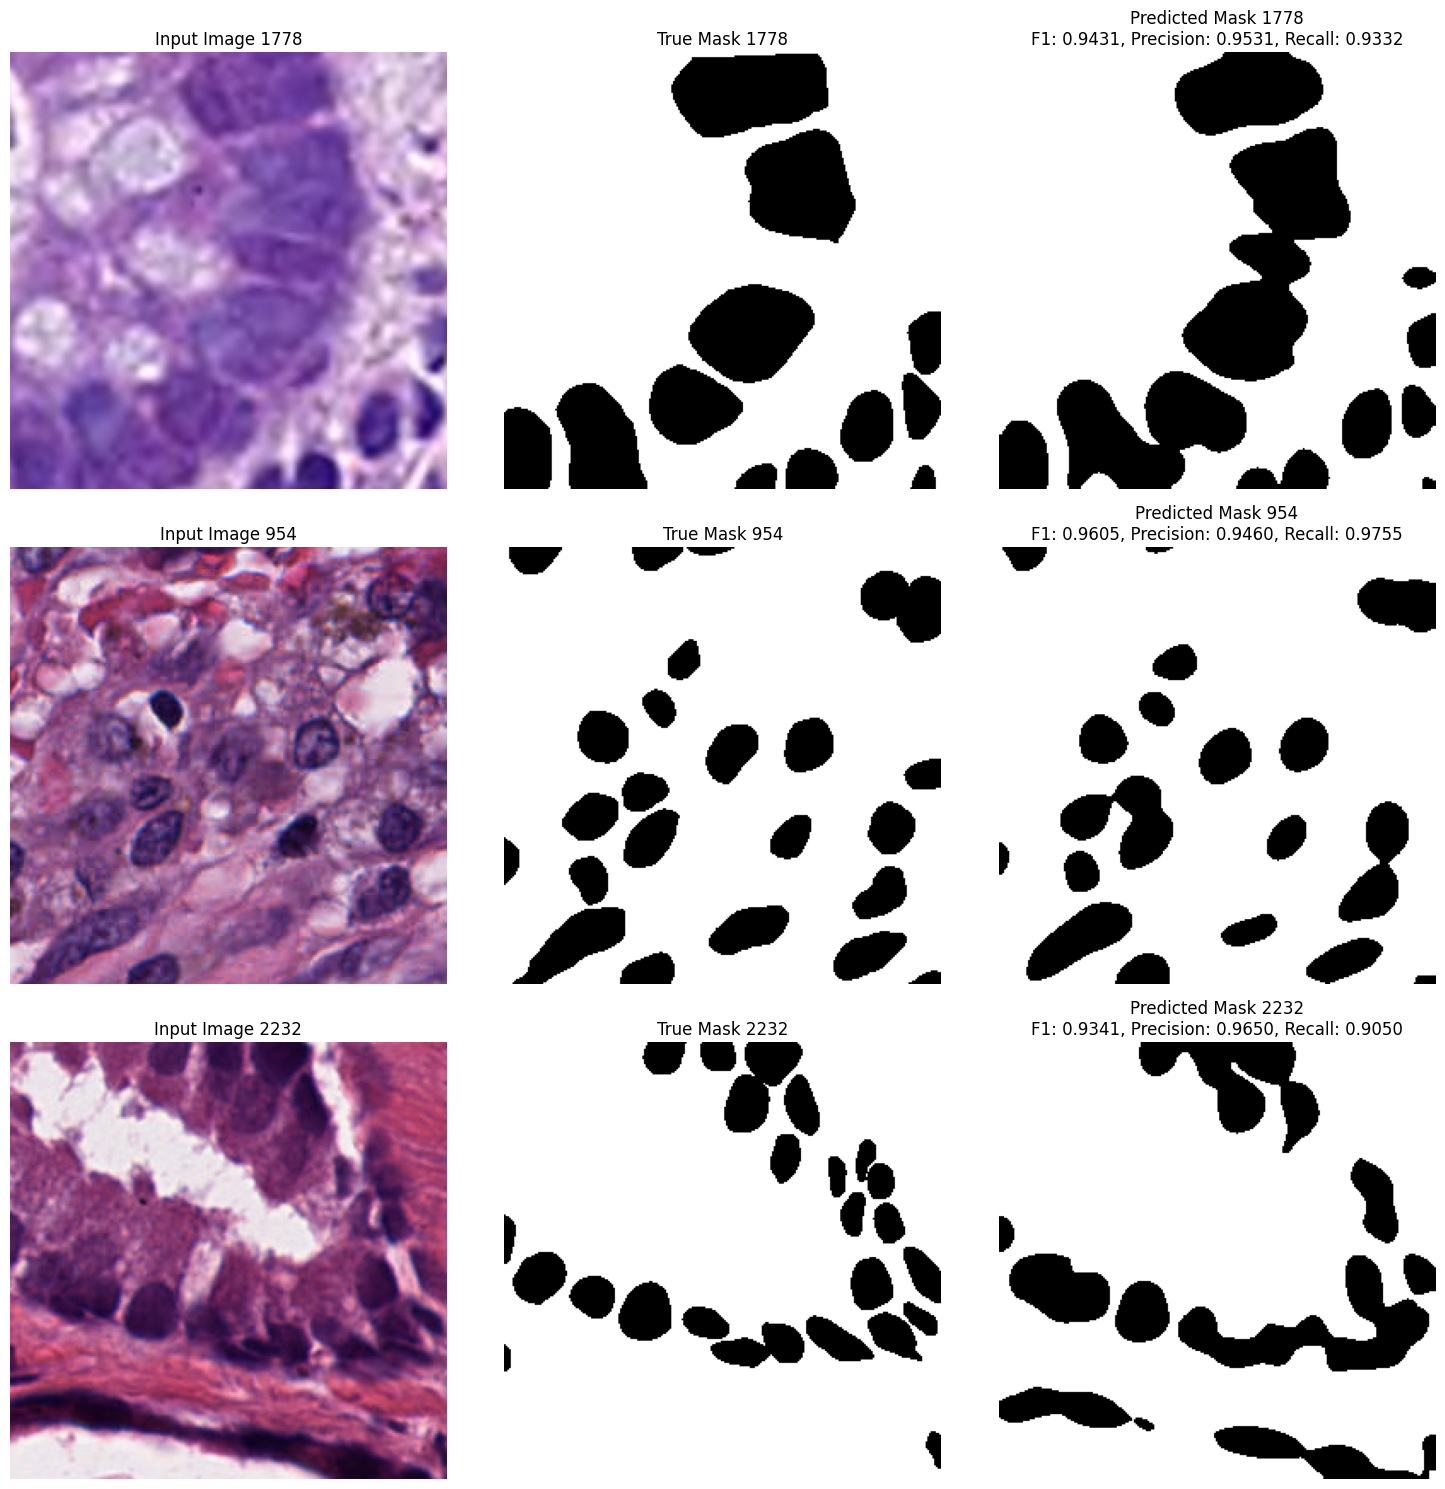

Overall Metrics (average of 3 samples):
F1 Score: 0.9459
Precision: 0.9547
Recall: 0.9379


In [19]:
model = trained_model  # Your trained CellViT model
test_dataset = CellSegmentationDataset(
    data_splits[chosen_split]['test']['images'],
    data_splits[chosen_split]['test']['masks'],
    image_transform=image_transform,
    mask_transform=mask_transform
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Visualize and calculate metrics
visualize_prediction_with_metrics(model, test_dataset, device, num_samples=3)

## new metrics

In [14]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
from skimage import measure  # Add this line

def pair_coordinates(true_centroids, pred_centroids, pairing_radius):
    if len(true_centroids) == 0 or len(pred_centroids) == 0:
        return np.array([]), np.arange(len(true_centroids)), np.arange(len(pred_centroids))
    
    # Ensure we're only using x and y coordinates
    true_centroids = true_centroids[:, :2]
    pred_centroids = pred_centroids[:, :2]
    
    distances = np.linalg.norm(true_centroids[:, None] - pred_centroids[None, :], axis=-1)
    true_indices, pred_indices = linear_sum_assignment(distances)
    
    paired = []
    unpaired_true = []
    unpaired_pred = []
    
    for true_idx, pred_idx in zip(true_indices, pred_indices):
        if distances[true_idx, pred_idx] <= pairing_radius:
            paired.append((true_idx, pred_idx))
        else:
            unpaired_true.append(true_idx)
            unpaired_pred.append(pred_idx)
    
    return np.array(paired), np.array(unpaired_true), np.array(unpaired_pred)

def calculate_instance_map(binary_mask):
    from skimage import measure
    return measure.label(binary_mask)

def get_centroids(instance_map):
    props = measure.regionprops(instance_map)
    centroids = np.array([prop.centroid for prop in props])
    if centroids.size == 0:
        return np.empty((0, 2))  # Return empty 2D array if no centroids
    elif centroids.ndim == 1:
        return centroids.reshape(1, -1)  # Single centroid, reshape to 2D
    else:
        return centroids[:, :2]  # Return only x and y coordinates for 3D centroids

def cell_detection_scores(paired_true, paired_pred, unpaired_true, unpaired_pred):
    tp = len(paired_true)
    fp = len(unpaired_pred)
    fn = len(unpaired_true)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return f1, precision, recall

def calculate_metrics_across_all_test_sets(model, test_dataset, device, batch_size=32, pairing_radius=12):
    model.eval()
    
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    paired_all_global = []
    unpaired_true_all_global = []
    unpaired_pred_all_global = []
    
    with torch.no_grad():
        for images, masks in tqdm(test_dataloader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)
            
            if images.dim() == 3:
                images = images.unsqueeze(1)
            
            if images.shape[-2:] != (224, 224):
                images = torch.nn.functional.interpolate(images, size=(256, 256), mode='bilinear', align_corners=False)
            
            outputs = model(images)
            pred_masks = (outputs > 0.5).float()
            
            if pred_masks.shape[-2:] != masks.shape[-2:]:
                pred_masks = torch.nn.functional.interpolate(pred_masks, size=masks.shape[-2:], mode='nearest')
            
            for true_mask, pred_mask in zip(masks.cpu().numpy(), pred_masks.cpu().numpy()):
                true_instance_map = calculate_instance_map(true_mask)
                pred_instance_map = calculate_instance_map(pred_mask)
                
                true_centroids = get_centroids(true_instance_map)
                pred_centroids = get_centroids(pred_instance_map)
                
                paired, unpaired_true, unpaired_pred = pair_coordinates(true_centroids, pred_centroids, pairing_radius)
                
                paired_all_global.extend(paired.flatten())
                unpaired_true_all_global.extend(unpaired_true.flatten())
                unpaired_pred_all_global.extend(unpaired_pred.flatten())

    paired_all = np.array(paired_all_global).reshape(-1, 2)
    unpaired_true_all = np.array(unpaired_true_all_global)
    unpaired_pred_all = np.array(unpaired_pred_all_global)
    
    f1, precision, recall = cell_detection_scores(
        paired_true=paired_all[:, 0],
        paired_pred=paired_all[:, 1],
        unpaired_true=unpaired_true_all,
        unpaired_pred=unpaired_pred_all
    )
    
    print("Metrics across all test sets:")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    return f1, precision, recall

# Usage
model = trained_model  # Your trained CellViT model
test_dataset = CellSegmentationDataset(
    data_splits[chosen_split]['test']['images'],
    data_splits[chosen_split]['test']['masks'],
    image_transform=image_transform,
    mask_transform=mask_transform
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Calculate metrics across all test sets
f1, precision, recall = calculate_metrics_across_all_test_sets(model, test_dataset, device)

Evaluating: 100%|██████████| 79/79 [00:15<00:00,  5.27it/s]

Metrics across all test sets:
F1 Score: 0.8805
Precision: 0.8771
Recall: 0.8840
